In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/testing/gymming/src


In [2]:
import numpy as np
import torch

from concepts import concept_instances
from train_model import load_model
from utils import plot_obs

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = load_model("../runs/20230901-100931/models/model_5500000.pt").to(device)

In [4]:
concept = concept_instances[5]
print(concept.name)

ball left paddle


In [5]:
layer = 3
cav = concept.load_cav(layer)
cav = torch.from_numpy(cav).unsqueeze(0).to(device)
print(cav.shape) # note CAV is flattened...

def forward_hook_fn(m, i, o):
    global activation
    activation = o

def backward_hook_fn(m, i, o):
    global gradient_input, gradient_output
    gradient_input = i[0]
    gradient_output = o[0]
        
q_network.network[layer].register_forward_hook(forward_hook_fn)
q_network.network[layer].register_backward_hook(backward_hook_fn)

torch.Size([1, 5184])


torch.Size([1, 4, 84, 84])


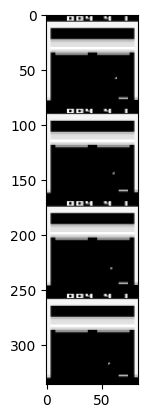

In [6]:
example = concept.get_presence_observations()[0]
example = torch.from_numpy(example).unsqueeze(0).to(device).float()
print(example.shape)
plot_obs(example)

In [7]:
q_network(example)
cav = cav.reshape(activation.shape) # need to reshape CAV to match activation shape
cav = cav / torch.norm(cav)

### Finite difference to get CAV importance for each action

In [8]:
h = 1e-3

# positive cav direction (forward fd)
with torch.no_grad():
    # normal forward of example
    o0 = q_network(example)
    perturb = h * cav
    # perturb example activations
    activation1 = activation.clone() + perturb
    # forward of perturbed activations
    o1 = q_network.network[layer + 1:](activation1)
    diff = (o1 - o0) / h
    print(o0)
    print(o1)
    print(diff)
    print(diff.sum())

tensor([[4.6027, 4.5793, 4.4404, 4.6226]], device='cuda:0')
tensor([[4.6026, 4.5792, 4.4404, 4.6225]], device='cuda:0')
tensor([[-0.0806, -0.0753,  0.0014, -0.0873]], device='cuda:0')
tensor(-0.2418, device='cuda:0')


### autograd CAV importance (doesnt look correct...)

In [9]:
cav_ = np.reshape(cav.detach().cpu().numpy(), -1)

In [10]:
o0 = q_network(example)
print(o0)
o0.backward(torch.ones_like(o0))
grad = np.reshape(gradient_input.detach().cpu().numpy(), -1)
print(np.dot(grad, cav_))

tensor([[4.6027, 4.5793, 4.4404, 4.6226]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
-0.0113541335


In [11]:
s = 0

o0 = q_network(example)
print(o0)
o0[0][0].backward(retain_graph=True)
grad = np.reshape(gradient_output.detach().cpu().numpy(), -1)
print(np.dot(grad, cav_))
s += np.dot(grad, cav_)

o0 = q_network(example)
o0[0][1].backward(retain_graph=True)
grad = np.reshape(gradient_output.detach().cpu().numpy(), -1)
print(np.dot(grad, cav_))
s += np.dot(grad, cav_)

o0 = q_network(example)
o0[0][2].backward(retain_graph=True)
grad = np.reshape(gradient_output.detach().cpu().numpy(), -1)
print(np.dot(grad, cav_))
s += np.dot(grad, cav_)

o0 = q_network(example)
o0[0][3].backward(retain_graph=True)
grad = np.reshape(gradient_output.detach().cpu().numpy(), -1)
print(np.dot(grad, cav_))
s += np.dot(grad, cav_)

print(s/4)

tensor([[4.6027, 4.5793, 4.4404, 4.6226]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
-0.10607363
-0.103174336
-0.10388821
-0.098189816
-0.10283149965107441


### CAV importance using direction

In [12]:
h = 1e-6
perturb = h * cav
counter = [0] * 4
examples = concept.get_presence_observations()
total = len(examples)
#examples = concept.get_absence_observations()
with torch.no_grad():
    for example in examples:
        example = torch.from_numpy(example).unsqueeze(0).to(device).float()
        # normal forward of example
        o0 = q_network(example)
        # perturb example activations
        activation1 = activation.clone() + perturb
        # forward of perturbed activations
        o1 = q_network.network[layer + 1:](activation1)
        diff = (o1 - o0) / h
        for i in range(4):
            if diff[0][i] > 0:
                counter[i] += 1

counter = np.array(counter)
print(counter / total)

[0.09 0.08 0.1  0.08]
